In [2]:
import pandas as pd

# Step 1: Load Excel files and get all sheet names
forest_file = 'Bird_Monitoring_Data_FOREST.XLSX'
grassland_file = 'Bird_Monitoring_Data_GRASSLAND.XLSX'

forest_sheets = pd.ExcelFile(forest_file).sheet_names
grassland_sheets = pd.ExcelFile(grassland_file).sheet_names

print("Forest Sheets:", forest_sheets)
print("Grassland Sheets:", grassland_sheets)



Forest Sheets: ['ANTI', 'CATO', 'CHOH', 'GWMP', 'HAFE', 'MANA', 'MONO', 'NACE', 'PRWI', 'ROCR', 'WOTR']
Grassland Sheets: ['ANTI', 'CATO', 'CHOH', 'GWMP', 'HAFE', 'MANA', 'MONO', 'NACE', 'PRWI', 'ROCR', 'WOTR']


In [3]:
# Reading and taging all forest sheets (skipping completely empty ones)
forest_data = pd.concat([
    df.assign(Location_Type='Forest')
    for sheet in forest_sheets
    if not (df := pd.read_excel(forest_file, sheet_name=sheet)).empty
], ignore_index=True)

# Reading and taging all grassland sheets (skiping completely empty ones)
grassland_data = pd.concat([
    df.assign(Location_Type='Grassland')
    for sheet in grassland_sheets
    if not (df := pd.read_excel(grassland_file, sheet_name=sheet)).empty
], ignore_index=True)



In [4]:
# Combine into one DataFrame
combined_data = pd.concat([forest_data, grassland_data], ignore_index=True)

# Preview
print("Shape of combined dataset:", combined_data.shape)
combined_data.head()


Shape of combined dataset: (17077, 32)


,Admin_Unit_Code,Sub_Unit_Code,Site_Name,Plot_Name,Location_Type,Year,Date,Start_Time,End_Time,Observer,...,Regional_Stewardship_Status,Temperature,Humidity,Sky,Wind,Disturbance,Initial_Three_Min_Cnt,Location_type,TaxonCode,Previously_Obs
0,ANTI,NaN,ANTI 1,ANTI-0036,Forest,2018,2018-05-22,06:19:00,06:29:00,Elizabeth Oswald,...,True,19.9,79.400002,Cloudy/Overcast,Calm (< 1 mph) smoke rises vertically,No effect on count,True,FOREST,NaN,NaN
1,ANTI,NaN,ANTI 1,ANTI-0036,Forest,2018,2018-05-22,06:19:00,06:29:00,Elizabeth Oswald,...,False,19.9,79.400002,Cloudy/Overcast,Calm (< 1 mph) smoke rises vertically,No effect on count,True,FOREST,NaN,NaN
2,ANTI,NaN,ANTI 1,ANTI-0036,Forest,2018,2018-05-22,06:19:00,06:29:00,Elizabeth Oswald,...,False,19.9,79.400002,Cloudy/Overcast,Calm (< 1 mph) smoke rises vertically,No effect on count,False,FOREST,NaN,NaN
3,ANTI,NaN,ANTI 1,ANTI-0036,Forest,2018,2018-05-22,06:19:00,06:29:00,Elizabeth Oswald,...,False,19.9,79.400002,Cloudy/Overcast,Calm (< 1 mph) smoke rises vertically,No effect on count,False,FOREST,NaN,NaN
4,ANTI,NaN,ANTI 1,ANTI-0036,Forest,2018,2018-05-22,06:19:00,06:29:00,Elizabeth Oswald,...,False,19.9,79.400002,Cloudy/Overcast,Calm (< 1 mph) smoke rises vertically,No effect on count,False,FOREST,NaN,NaN


In [5]:
combined_data['Admin_Unit_Code'].unique()


array(['ANTI', 'CATO', 'CHOH', 'GWMP', 'HAFE', 'MANA', 'MONO', 'NACE',
       'PRWI', 'ROCR', 'WOTR'], dtype=object)

In [6]:
combined_data['Admin_Unit_Code'].value_counts()


Admin_Unit_Code
ANTI    3921
MONO    3385
PRWI    2463
MANA    2276
CHOH    2202
CATO     805
NACE     684
HAFE     539
GWMP     386
ROCR     289
WOTR     127
Name: count, dtype: int64

In [7]:
combined_data.groupby(['Admin_Unit_Code', 'Location_Type']).size().unstack()


Location_Type,Forest,Grassland
Admin_Unit_Code,,
ANTI,333.0,3588.0
CATO,805.0,NaN
CHOH,2202.0,NaN
GWMP,386.0,NaN
HAFE,422.0,117.0
MANA,465.0,1811.0
MONO,370.0,3015.0
NACE,684.0,NaN
PRWI,2463.0,NaN


In [8]:
combined_data['Date'] = pd.to_datetime(combined_data['Date'], errors='coerce')

In [9]:
combined_data['Year'] = combined_data['Date'].dt.year
combined_data['Month'] = combined_data['Date'].dt.month


In [10]:
def get_season(month):
    if pd.isna(month): return None
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [11]:
combined_data['Season'] = combined_data['Month'].apply(get_season)

In [12]:
# Cleans 'ID_Method' column: removes extra spaces, capitalizes properly
combined_data['ID_Method'] = combined_data['ID_Method'].astype(str).str.strip().str.capitalize()

# Cleans 'Distance' column: removes spaces, makes uppercase (e.g., '<= 50 METERS')
combined_data['Distance'] = combined_data['Distance'].astype(str).str.strip().str.upper()

# Fills missing 'Sex' values with 'Undetermined' and standardizes the format
combined_data['Sex'] = combined_data['Sex'].fillna('Undetermined').astype(str).str.capitalize()

# Cleans 'Flyover_Observed' column and converts TRUE/FALSE to Yes/No
combined_data['Flyover_Observed'] = combined_data['Flyover_Observed'].astype(str).str.strip().str.upper()
combined_data['Flyover_Observed'] = combined_data['Flyover_Observed'].replace({'TRUE': 'Yes', 'FALSE': 'No'})


In [13]:
# Fill missing 'Temperature' with the median temperature (a good central value)
combined_data['Temperature'] = combined_data['Temperature'].fillna(combined_data['Temperature'].median())

# Fill missing 'Humidity' with the median humidity
combined_data['Humidity'] = combined_data['Humidity'].fillna(combined_data['Humidity'].median())

# Fill missing weather condition values with 'Unknown'
combined_data['Sky'] = combined_data['Sky'].fillna('Unknown')
combined_data['Wind'] = combined_data['Wind'].fillna('Unknown')

# Fill missing disturbance info with a placeholder
combined_data['Disturbance'] = combined_data['Disturbance'].fillna('No effect')

# Fill missing initial 3-min count with 0 (assuming no bird was observed)
combined_data['Initial_Three_Min_Cnt'] = combined_data['Initial_Three_Min_Cnt'].fillna(0)


In [14]:
# Remove rows where 'Scientific_Name' is missing (we can't analyze unidentified species)
combined_data = combined_data.dropna(subset=['Scientific_Name'])

# Drop any columns that are entirely missing (optional cleanup)
combined_data = combined_data.dropna(axis=1, how='all')


In [15]:
combined_data.head()

,Admin_Unit_Code,Sub_Unit_Code,Site_Name,Plot_Name,Location_Type,Year,Date,Start_Time,End_Time,Observer,...,Humidity,Sky,Wind,Disturbance,Initial_Three_Min_Cnt,Location_type,TaxonCode,Previously_Obs,Month,Season
0,ANTI,NaN,ANTI 1,ANTI-0036,Forest,2018,2018-05-22,06:19:00,06:29:00,Elizabeth Oswald,...,79.400002,Cloudy/Overcast,Calm (< 1 mph) smoke rises vertically,No effect on count,True,FOREST,NaN,NaN,5,Spring
1,ANTI,NaN,ANTI 1,ANTI-0036,Forest,2018,2018-05-22,06:19:00,06:29:00,Elizabeth Oswald,...,79.400002,Cloudy/Overcast,Calm (< 1 mph) smoke rises vertically,No effect on count,True,FOREST,NaN,NaN,5,Spring
2,ANTI,NaN,ANTI 1,ANTI-0036,Forest,2018,2018-05-22,06:19:00,06:29:00,Elizabeth Oswald,...,79.400002,Cloudy/Overcast,Calm (< 1 mph) smoke rises vertically,No effect on count,False,FOREST,NaN,NaN,5,Spring
3,ANTI,NaN,ANTI 1,ANTI-0036,Forest,2018,2018-05-22,06:19:00,06:29:00,Elizabeth Oswald,...,79.400002,Cloudy/Overcast,Calm (< 1 mph) smoke rises vertically,No effect on count,False,FOREST,NaN,NaN,5,Spring
4,ANTI,NaN,ANTI 1,ANTI-0036,Forest,2018,2018-05-22,06:19:00,06:29:00,Elizabeth Oswald,...,79.400002,Cloudy/Overcast,Calm (< 1 mph) smoke rises vertically,No effect on count,False,FOREST,NaN,NaN,5,Spring


In [16]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17077 entries, 0 to 17076
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Admin_Unit_Code              17077 non-null  object        
 1   Sub_Unit_Code                722 non-null    object        
 2   Site_Name                    8546 non-null   object        
 3   Plot_Name                    17077 non-null  object        
 4   Location_Type                17077 non-null  object        
 5   Year                         17077 non-null  int32         
 6   Date                         17077 non-null  datetime64[ns]
 7   Start_Time                   17077 non-null  object        
 8   End_Time                     17077 non-null  object        
 9   Observer                     17077 non-null  object        
 10  Visit                        17077 non-null  int64         
 11  Interval_Length              17077 non-nu

In [17]:
combined_data.isnull().sum()

Admin_Unit_Code                    0
Sub_Unit_Code                  16355
Site_Name                       8531
Plot_Name                          0
Location_Type                      0
Year                               0
Date                               0
Start_Time                         0
End_Time                           0
Observer                           0
Visit                              0
Interval_Length                    0
ID_Method                          0
Distance                           0
Flyover_Observed                   0
Sex                                0
Common_Name                        0
Scientific_Name                    0
AcceptedTSN                       33
NPSTaxonCode                    8531
AOU_Code                           0
PIF_Watchlist_Status               0
Regional_Stewardship_Status        0
Temperature                        0
Humidity                           0
Sky                                0
Wind                               0
D

In [18]:
# Droping typo column and unused extras
combined_data = combined_data.drop(columns=[
    'Location_type',  # duplicate of 'Location_Type'
    'TaxonCode',
    'Previously_Obs'
])


In [19]:
# Optional: If needed, fill missing TSNs with -1 or drop those rows
combined_data['AcceptedTSN'] = combined_data['AcceptedTSN'].fillna(-1)

In [20]:
combined_data.info()
combined_data.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17077 entries, 0 to 17076
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Admin_Unit_Code              17077 non-null  object        
 1   Sub_Unit_Code                722 non-null    object        
 2   Site_Name                    8546 non-null   object        
 3   Plot_Name                    17077 non-null  object        
 4   Location_Type                17077 non-null  object        
 5   Year                         17077 non-null  int32         
 6   Date                         17077 non-null  datetime64[ns]
 7   Start_Time                   17077 non-null  object        
 8   End_Time                     17077 non-null  object        
 9   Observer                     17077 non-null  object        
 10  Visit                        17077 non-null  int64         
 11  Interval_Length              17077 non-nu

Admin_Unit_Code                    0
Sub_Unit_Code                  16355
Site_Name                       8531
Plot_Name                          0
Location_Type                      0
Year                               0
Date                               0
Start_Time                         0
End_Time                           0
Observer                           0
Visit                              0
Interval_Length                    0
ID_Method                          0
Distance                           0
Flyover_Observed                   0
Sex                                0
Common_Name                        0
Scientific_Name                    0
AcceptedTSN                        0
NPSTaxonCode                    8531
AOU_Code                           0
PIF_Watchlist_Status               0
Regional_Stewardship_Status        0
Temperature                        0
Humidity                           0
Sky                                0
Wind                               0
D

<Axes: title={'center': 'Number of Observations Per Year'}, xlabel='Year', ylabel='Observation Count'>

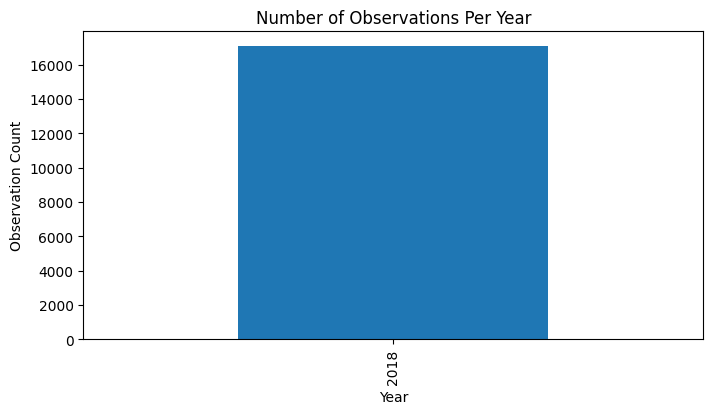

In [24]:
combined_data['Year'].value_counts().sort_index().plot(
    kind='bar',
    title='Number of Observations Per Year',
    xlabel='Year',
    ylabel='Observation Count',
    figsize=(8, 4)
)


<Axes: title={'center': 'Number of Observations by Season'}, xlabel='Season', ylabel='Observation Count'>

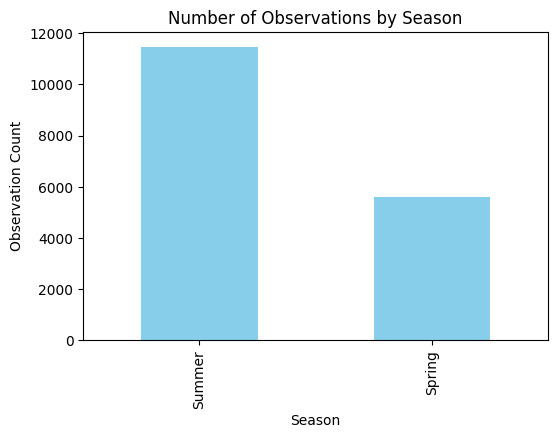

In [25]:
combined_data['Season'].value_counts().plot(
    kind='bar',
    title='Number of Observations by Season',
    xlabel='Season',
    ylabel='Observation Count',
    color='skyblue',
    figsize=(6, 4)
)


<Axes: title={'center': 'Unique Species Observed by Season'}, xlabel='Season', ylabel='Unique Species Count'>

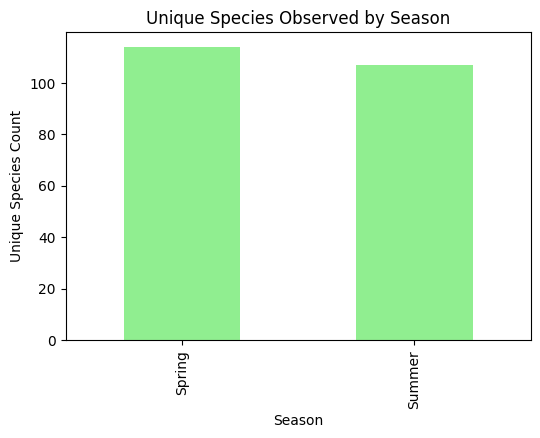

In [26]:
combined_data.groupby('Season')['Scientific_Name'].nunique().plot(
    kind='bar',
    title='Unique Species Observed by Season',
    xlabel='Season',
    ylabel='Unique Species Count',
    color='lightgreen',
    figsize=(6, 4)
)


In [32]:
combined_data['Start_Time'].dropna().astype(str).unique()[:20]


array(['06:19:00', '06:02:00', '07:21:00', '08:28:00', '09:26:00',
       '10:01:00', '07:09:00', '08:34:00', '07:22:00', '09:53:00',
       '10:10:00', '10:27:00', '10:43:00', '05:40:00', '08:17:00',
       '06:12:00', '05:31:00', '08:14:00', '10:31:00', '07:27:00'],
      dtype=object)

In [33]:
# Convert Start_Time to datetime and extract the hour
combined_data['Start_Hour'] = pd.to_datetime(combined_data['Start_Time'], format='%H:%M:%S', errors='coerce').dt.hour


In [34]:
print("Unique Start Hours:", combined_data['Start_Hour'].dropna().unique())


Unique Start Hours: [ 6  7  8  9 10  5]


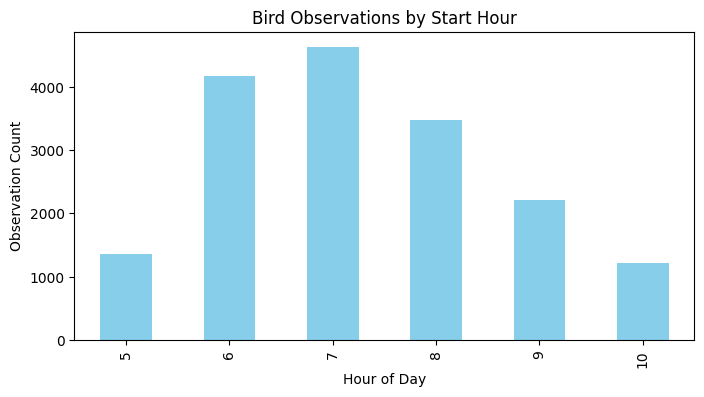

In [35]:
# Plot only if there are valid values
if combined_data['Start_Hour'].notnull().sum() > 0:
    combined_data['Start_Hour'].value_counts().sort_index().plot(
        kind='bar',
        title='Bird Observations by Start Hour',
        xlabel='Hour of Day',
        ylabel='Observation Count',
        figsize=(8, 4),
        color='skyblue'
    )
else:
    print("Start_Hour is empty. Cannot plot.")


In [36]:
combined_data['End_Hour'] = pd.to_datetime(combined_data['End_Time'], format='%H:%M:%S', errors='coerce').dt.hour


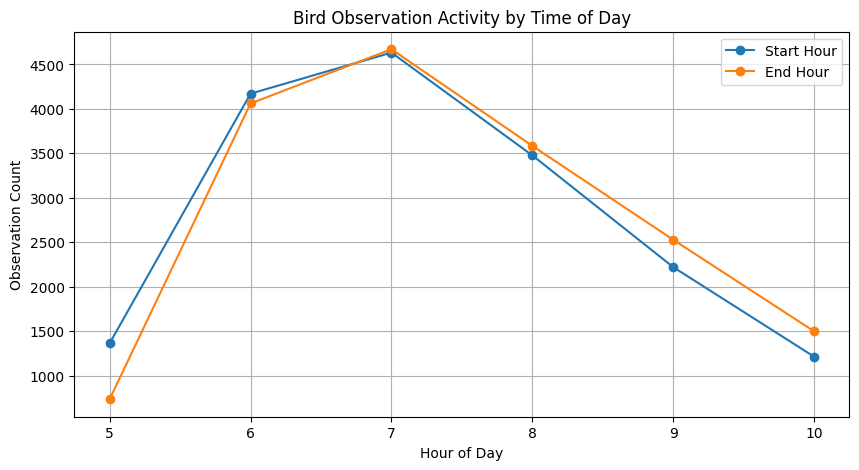

In [37]:
import matplotlib.pyplot as plt

start = combined_data['Start_Hour'].value_counts().sort_index()
end = combined_data['End_Hour'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.plot(start.index, start.values, label='Start Hour', marker='o')
plt.plot(end.index, end.values, label='End Hour', marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Observation Count')
plt.title('Bird Observation Activity by Time of Day')
plt.legend()
plt.grid(True)
plt.show()


<Axes: title={'center': 'Unique Species per Habitat Type'}, xlabel='Location Type', ylabel='Unique Species Count'>

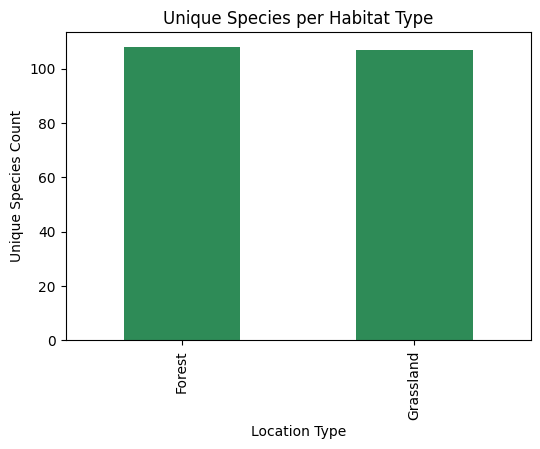

In [38]:
# Count of unique species in each Location_Type
combined_data.groupby('Location_Type')['Scientific_Name'].nunique().plot(
    kind='bar',
    title='Unique Species per Habitat Type',
    xlabel='Location Type',
    ylabel='Unique Species Count',
    color='seagreen',
    figsize=(6, 4)
)


<Axes: title={'center': 'Total Observations per Habitat Type'}, xlabel='Location Type', ylabel='Observation Count'>

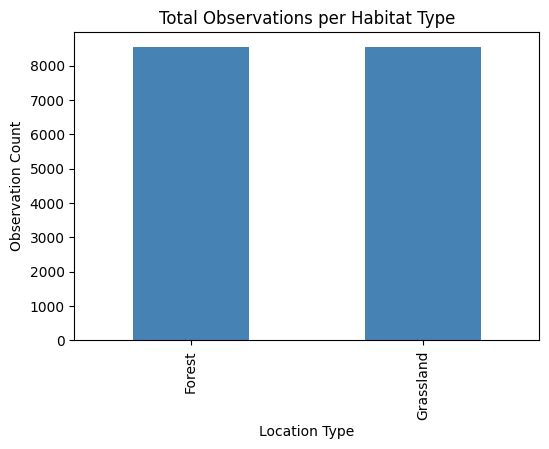

In [39]:
# Total number of observations by habitat
combined_data['Location_Type'].value_counts().plot(
    kind='bar',
    title='Total Observations per Habitat Type',
    xlabel='Location Type',
    ylabel='Observation Count',
    color='steelblue',
    figsize=(6, 4)
)


<Axes: title={'center': 'Top 10 Plots by Species Diversity'}, xlabel='Plot Name', ylabel='Unique Species Count'>

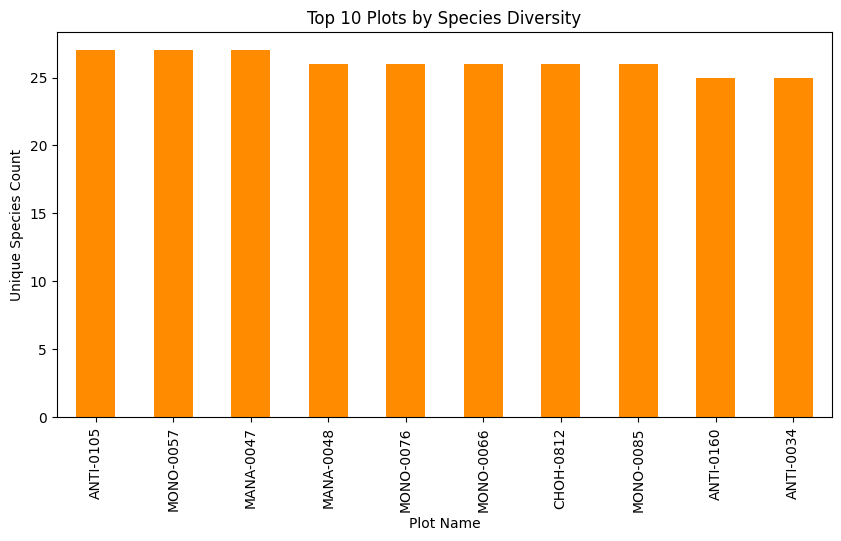

In [40]:
# Top 10 plots with most unique bird species
top_species_plots = combined_data.groupby('Plot_Name')['Scientific_Name'].nunique().sort_values(ascending=False).head(10)

top_species_plots.plot(
    kind='bar',
    title='Top 10 Plots by Species Diversity',
    xlabel='Plot Name',
    ylabel='Unique Species Count',
    color='darkorange',
    figsize=(10, 5)
)


<Axes: title={'center': 'Top 10 Plots by Observation Count'}, xlabel='Plot Name', ylabel='Total Observations'>

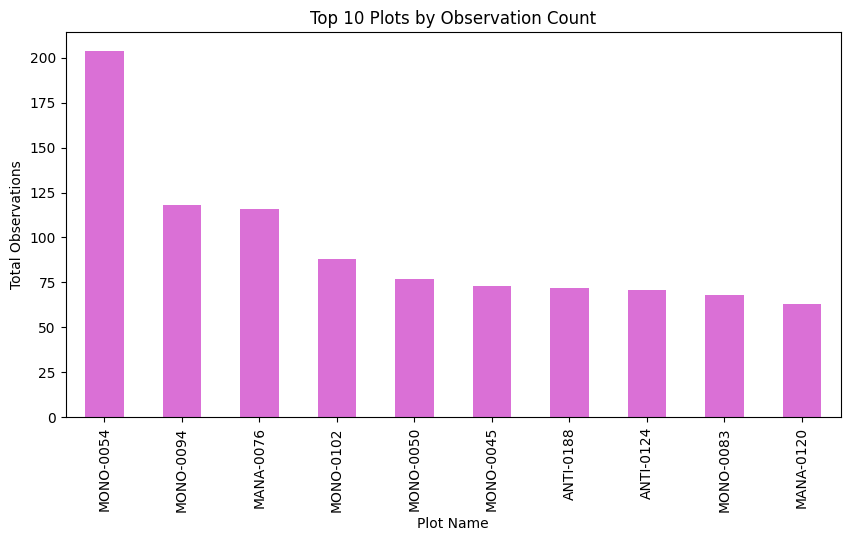

In [41]:
# Top 10 plots with most total bird observations
top_observation_plots = combined_data['Plot_Name'].value_counts().head(10)

top_observation_plots.plot(
    kind='bar',
    title='Top 10 Plots by Observation Count',
    xlabel='Plot Name',
    ylabel='Total Observations',
    color='orchid',
    figsize=(10, 5)
)


In [42]:
# Unique species per plot, grouped by habitat
plot_richness = combined_data.groupby(['Location_Type', 'Plot_Name'])['Scientific_Name'].nunique().reset_index()

# Top 5 richest plots in Forest
forest_top5 = plot_richness[plot_richness['Location_Type'] == 'Forest'].sort_values(by='Scientific_Name', ascending=False).head(5)

# Top 5 richest plots in Grassland
grassland_top5 = plot_richness[plot_richness['Location_Type'] == 'Grassland'].sort_values(by='Scientific_Name', ascending=False).head(5)

print("🌲 Top Forest Plots by Diversity:\n", forest_top5)
print("\n🌾 Top Grassland Plots by Diversity:\n", grassland_top5)


🌲 Top Forest Plots by Diversity:
     Location_Type  Plot_Name  Scientific_Name
97         Forest  CHOH-0812               26
248        Forest  NACE-0477               23
73         Forest  CHOH-0262               22
209        Forest  MANA-0240               22
78         Forest  CHOH-0380               22

🌾 Top Grassland Plots by Diversity:
     Location_Type  Plot_Name  Scientific_Name
441     Grassland  ANTI-0105               27
574     Grassland  MONO-0057               27
502     Grassland  MANA-0047               27
581     Grassland  MONO-0066               26
589     Grassland  MONO-0076               26


In [43]:
total_species = combined_data['Scientific_Name'].nunique()
print("Total Unique Species Observed:", total_species)

Total Unique Species Observed: 127


Unique Species by Habitat Type:
 Location_Type
Forest       108
Grassland    107
Name: Scientific_Name, dtype: int64


<Axes: title={'center': 'Unique Species by Habitat Type'}, xlabel='Location_Type'>

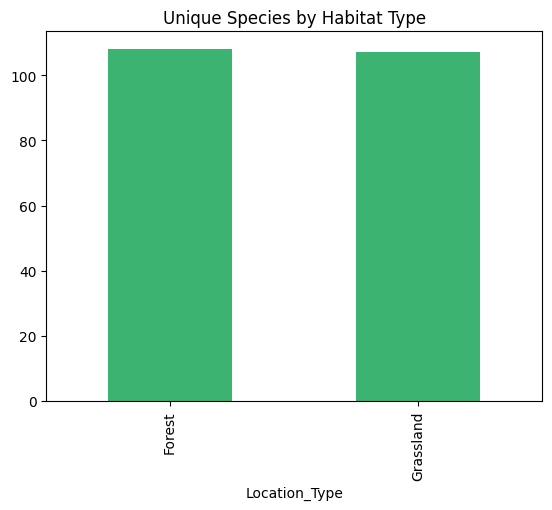

In [44]:
diversity_by_location = combined_data.groupby('Location_Type')['Scientific_Name'].nunique()
print("Unique Species by Habitat Type:\n", diversity_by_location)

# Optional bar plot
diversity_by_location.plot(kind='bar', title='Unique Species by Habitat Type', color='mediumseagreen')

<Axes: title={'center': 'Observation Duration Intervals'}, xlabel='Interval Length', ylabel='Observation Count'>

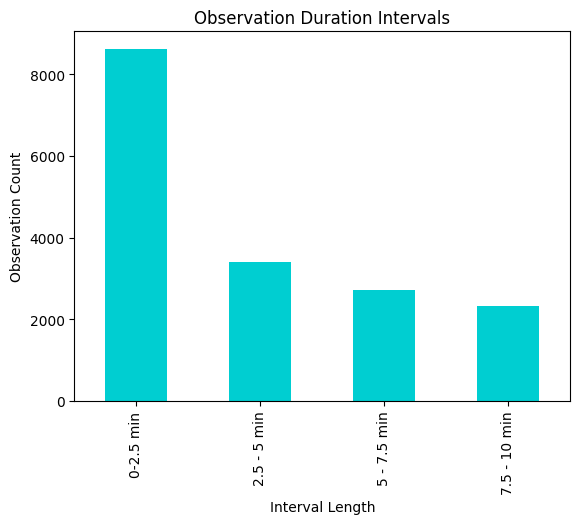

In [45]:
combined_data['Interval_Length'].value_counts().plot(
    kind='bar',
    title='Observation Duration Intervals',
    xlabel='Interval Length',
    ylabel='Observation Count',
    color='darkturquoise'
)


<Axes: title={'center': 'Bird Identification Methods'}, xlabel='ID Method (e.g., Singing, Calling, Visual)', ylabel='Frequency'>

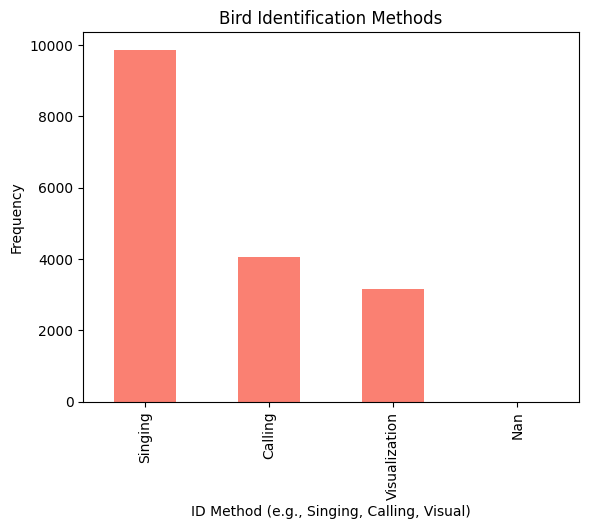

In [46]:
combined_data['ID_Method'].value_counts().plot(
    kind='bar',
    title='Bird Identification Methods',
    xlabel='ID Method (e.g., Singing, Calling, Visual)',
    ylabel='Frequency',
    color='salmon'
)


<Axes: title={'center': 'Sex Distribution of Observed Birds'}, ylabel='count'>

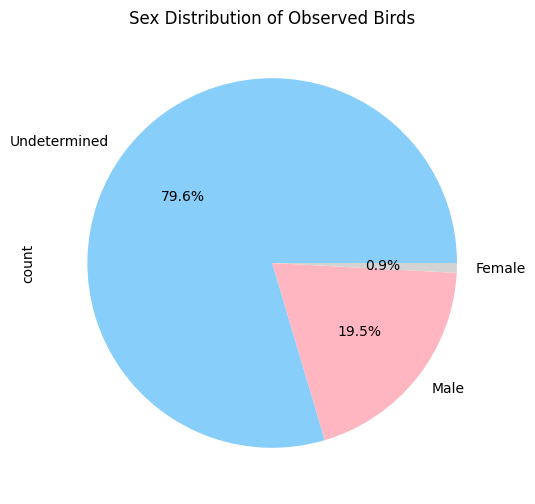

In [47]:
combined_data['Sex'].value_counts().plot(
    kind='pie',
    title='Sex Distribution of Observed Birds',
    autopct='%1.1f%%',
    figsize=(6, 6),
    colors=['lightskyblue', 'lightpink', 'lightgray']
)


<Axes: title={'center': 'Sex Distribution for Top 5 Species'}, xlabel='Scientific_Name'>

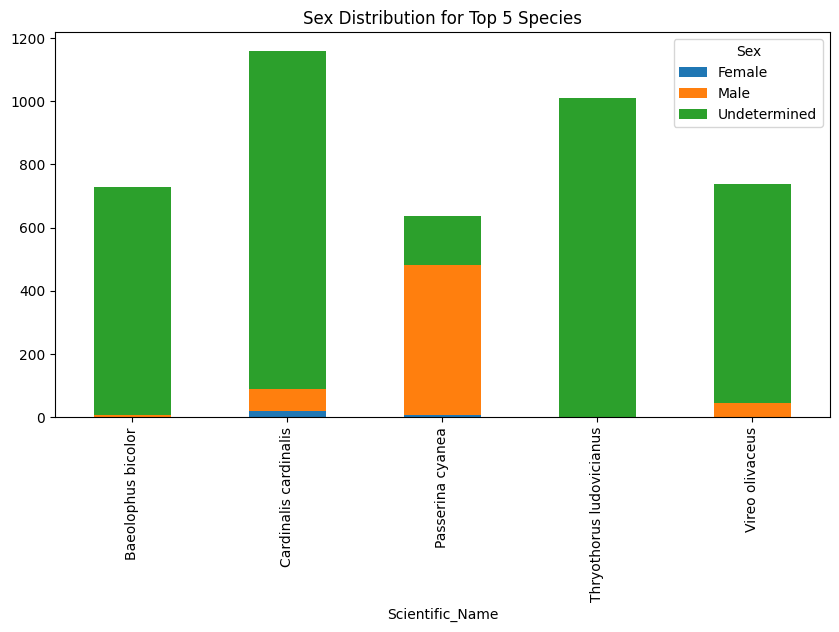

In [48]:
top_species = combined_data['Scientific_Name'].value_counts().head(5).index

sex_distribution = combined_data[combined_data['Scientific_Name'].isin(top_species)].groupby(['Scientific_Name', 'Sex']).size().unstack().fillna(0)

sex_distribution.plot(kind='bar', stacked=True, figsize=(10, 5), title='Sex Distribution for Top 5 Species')


<Axes: title={'center': 'Observations by Temperature Range'}, xlabel='Temperature Range', ylabel='Number of Observations'>

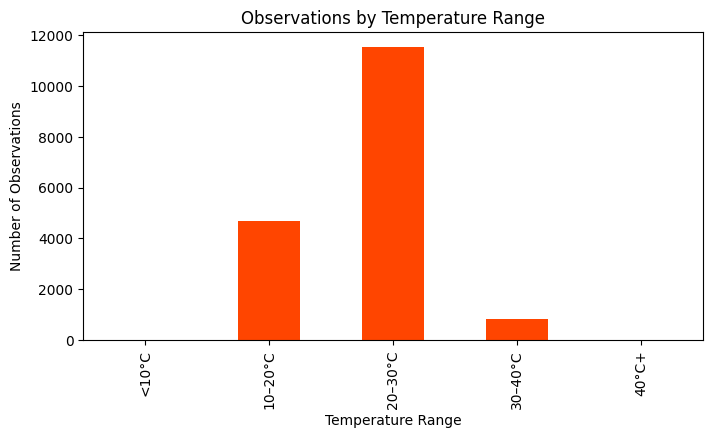

In [49]:
# Bin temperature into ranges
combined_data['Temp_Range'] = pd.cut(
    combined_data['Temperature'],
    bins=[-10, 10, 20, 30, 40, 50],
    labels=['<10°C', '10–20°C', '20–30°C', '30–40°C', '40°C+']
)

# Plot observations by temperature range
combined_data['Temp_Range'].value_counts().sort_index().plot(
    kind='bar',
    title='Observations by Temperature Range',
    xlabel='Temperature Range',
    ylabel='Number of Observations',
    color='orangered',
    figsize=(8, 4)
)


<Axes: title={'center': 'Observations by Humidity Range'}, xlabel='Humidity Range (%)', ylabel='Number of Observations'>

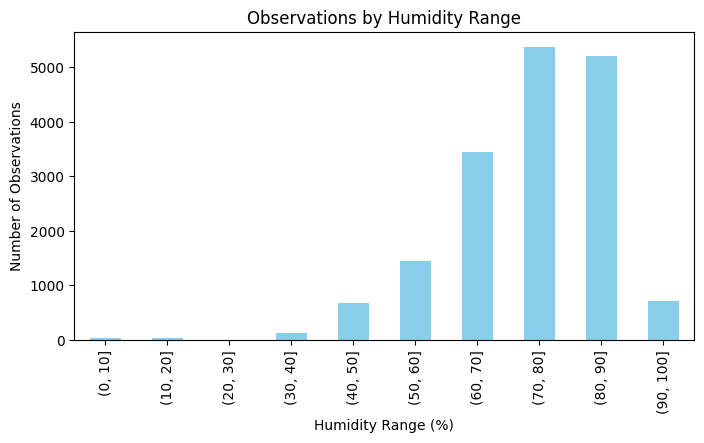

In [50]:
# Bin humidity into 10% intervals
combined_data['Humidity_Range'] = pd.cut(
    combined_data['Humidity'],
    bins=range(0, 110, 10)
)

# Plot observations by humidity
combined_data['Humidity_Range'].value_counts().sort_index().plot(
    kind='bar',
    title='Observations by Humidity Range',
    xlabel='Humidity Range (%)',
    ylabel='Number of Observations',
    color='skyblue',
    figsize=(8, 4)
)


<Axes: title={'center': 'Observations by Sky Condition'}, xlabel='Sky Condition', ylabel='Observation Count'>

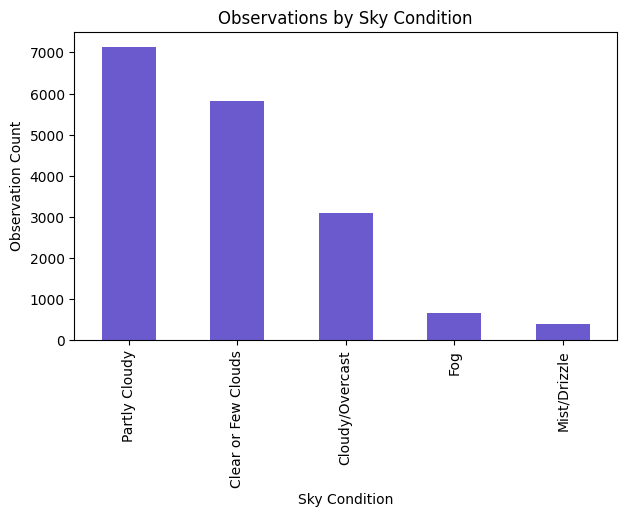

In [51]:
combined_data['Sky'].value_counts().plot(
    kind='bar',
    title='Observations by Sky Condition',
    xlabel='Sky Condition',
    ylabel='Observation Count',
    color='slateblue',
    figsize=(7, 4)
)


<Axes: title={'center': 'Observations by Wind Condition'}, xlabel='Wind Description', ylabel='Observation Count'>

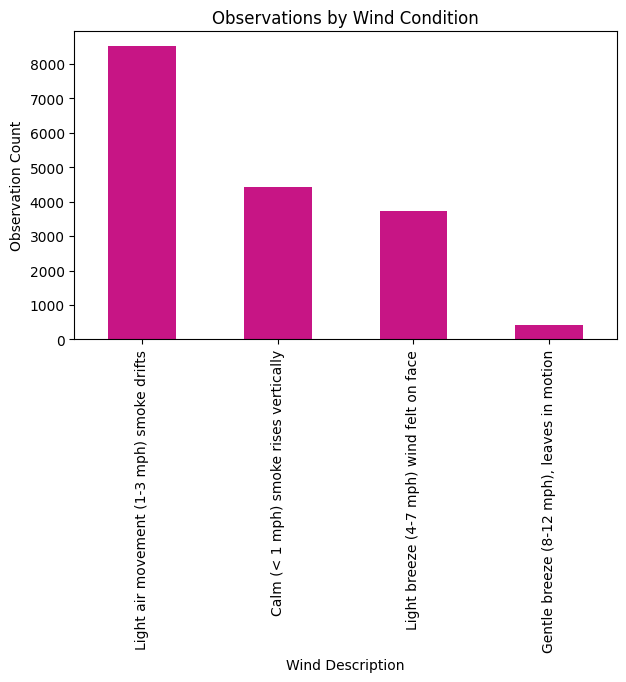

In [52]:
combined_data['Wind'].value_counts().plot(
    kind='bar',
    title='Observations by Wind Condition',
    xlabel='Wind Description',
    ylabel='Observation Count',
    color='mediumvioletred',
    figsize=(7, 4)
)

<Axes: title={'center': 'Observations by Disturbance Type'}, xlabel='Disturbance Level', ylabel='Observation Count'>

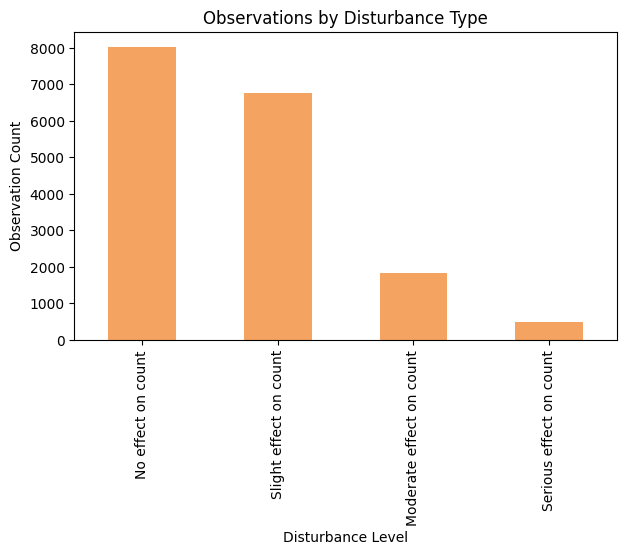

In [53]:
combined_data['Disturbance'].value_counts().plot(
    kind='bar',
    title='Observations by Disturbance Type',
    xlabel='Disturbance Level',
    ylabel='Observation Count',
    color='sandybrown',
    figsize=(7, 4)
)

<Axes: title={'center': 'Species Diversity by Disturbance Type'}, xlabel='Disturbance Type', ylabel='Unique Species Count'>

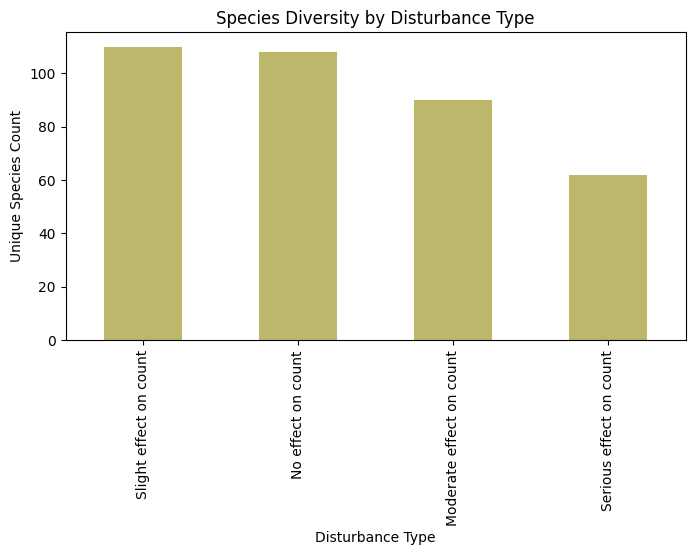

In [54]:
combined_data.groupby('Disturbance')['Scientific_Name'].nunique().sort_values(ascending=False).plot(
    kind='bar',
    title='Species Diversity by Disturbance Type',
    xlabel='Disturbance Type',
    ylabel='Unique Species Count',
    color='darkkhaki',
    figsize=(8, 4)
)

<Axes: title={'center': 'Bird Observation Count by Distance'}, xlabel='Observation Count', ylabel='Distance from Observer'>

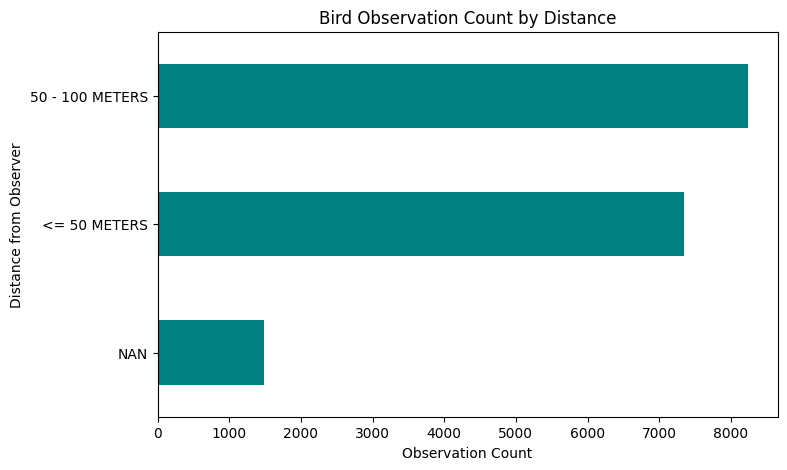

In [55]:
combined_data['Distance'].value_counts().sort_values().plot(
    kind='barh',
    title='Bird Observation Count by Distance',
    xlabel='Observation Count',
    ylabel='Distance from Observer',
    color='teal',
    figsize=(8, 5)
)


<Axes: title={'center': 'Species Diversity by Observation Distance'}, xlabel='Unique Species Count', ylabel='Distance'>

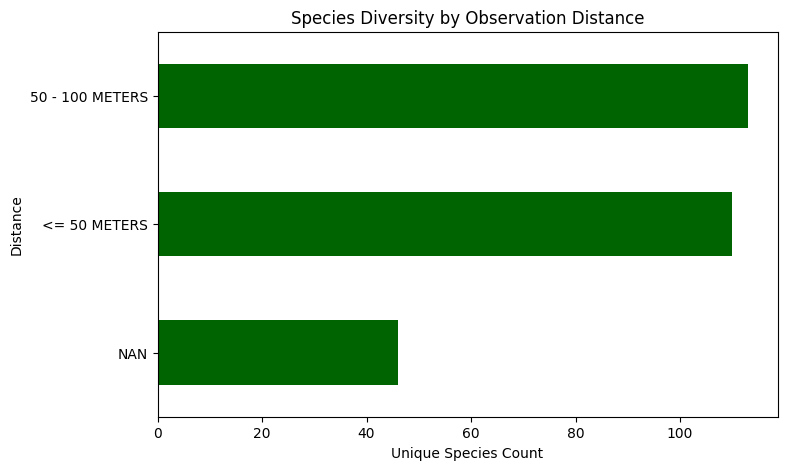

In [56]:
# Count of unique species observed in each distance category
combined_data.groupby('Distance')['Scientific_Name'].nunique().sort_values().plot(
    kind='barh',
    title='Species Diversity by Observation Distance',
    xlabel='Unique Species Count',
    ylabel='Distance',
    color='darkgreen',
    figsize=(8, 5)
)


<Axes: title={'center': 'Flyover Observations'}, ylabel='count'>

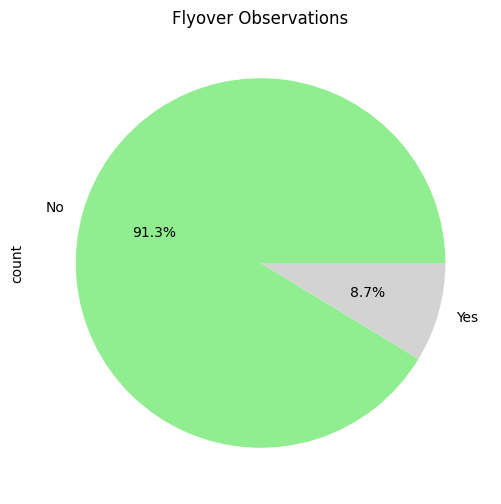

In [57]:
combined_data['Flyover_Observed'].value_counts().plot(
    kind='pie',
    title='Flyover Observations',
    autopct='%1.1f%%',
    colors=['lightgreen', 'lightgray'],
    figsize=(6, 6)
)


<Axes: title={'center': 'Top 10 Flyover Species'}, xlabel='Scientific Name', ylabel='Flyover Observations'>

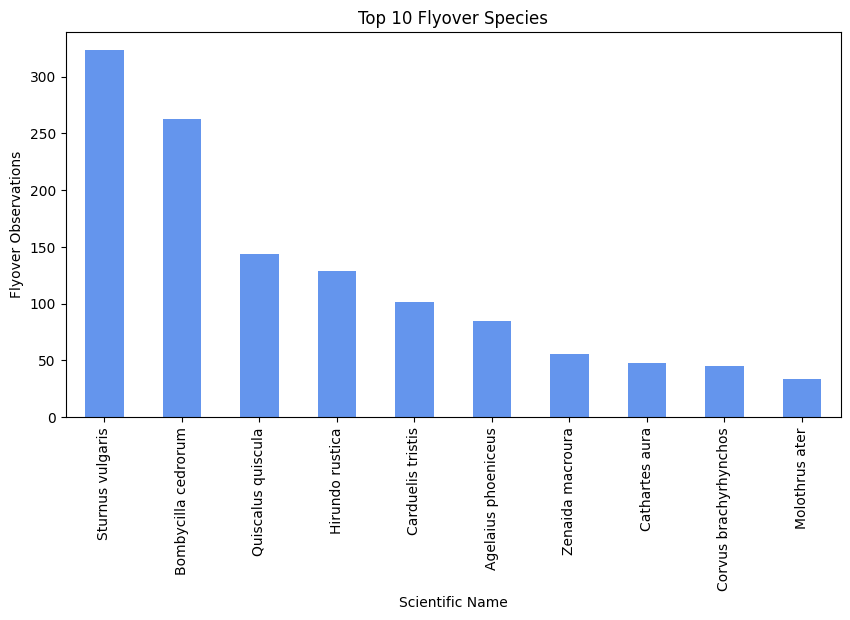

In [60]:
flyover_species = combined_data[combined_data['Flyover_Observed'] == 'Yes']

flyover_species['Scientific_Name'].value_counts().head(10).plot(
    kind='bar',
    title='Top 10 Flyover Species',
    xlabel='Scientific Name',
    ylabel='Flyover Observations',
    color='cornflowerblue',
    figsize=(10, 5)
)


<Axes: title={'center': 'Flyover Observations by Habitat Type'}, xlabel='Location_Type', ylabel='Count'>

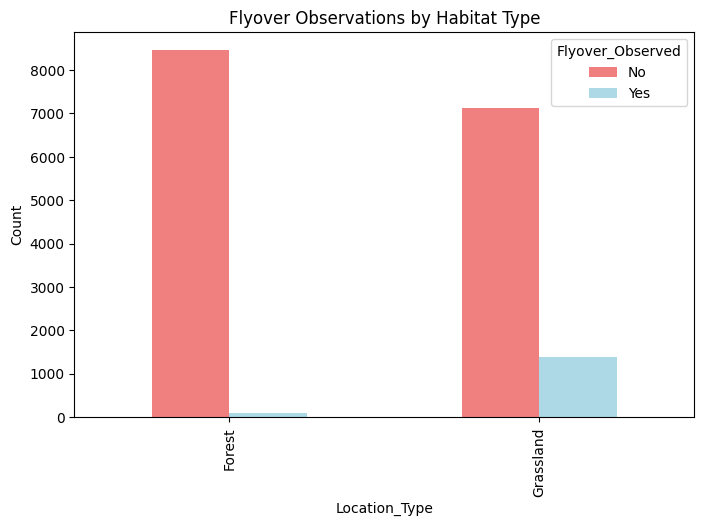

In [62]:
combined_data.groupby(['Location_Type', 'Flyover_Observed']).size().unstack().plot(
    kind='bar',
    title='Flyover Observations by Habitat Type',
    ylabel='Count',
    color=['lightcoral', 'lightblue'],
    figsize=(8, 5)
)

<Axes: title={'center': 'Top 10 Observers by Number of Observations'}, xlabel='Observer', ylabel='Total Observations'>

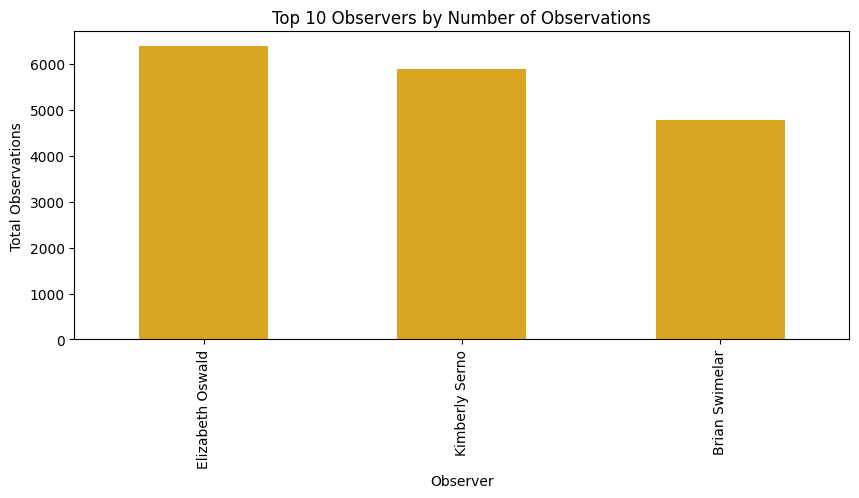

In [65]:
combined_data['Observer'].value_counts().head(10).plot(
    kind='bar',
    title='Top 10 Observers by Number of Observations',
    xlabel='Observer',
    ylabel='Total Observations',
    color='goldenrod',
    figsize=(10, 4)
)

<Axes: title={'center': 'Top 10 Observers by Species Diversity'}, xlabel='Observer', ylabel='Unique Species Observed'>

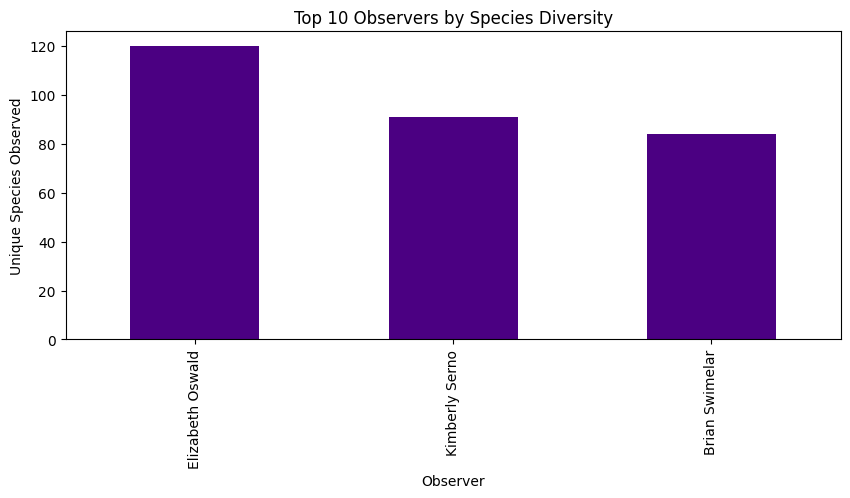

In [66]:
observer_species = combined_data.groupby('Observer')['Scientific_Name'].nunique().sort_values(ascending=False)

observer_species.head(10).plot(
    kind='bar',
    title='Top 10 Observers by Species Diversity',
    xlabel='Observer',
    ylabel='Unique Species Observed',
    color='indigo',
    figsize=(10, 4)
)

<Axes: title={'center': 'Species Diversity by Visit Number'}, xlabel='Visit Count', ylabel='Unique Species Observed'>

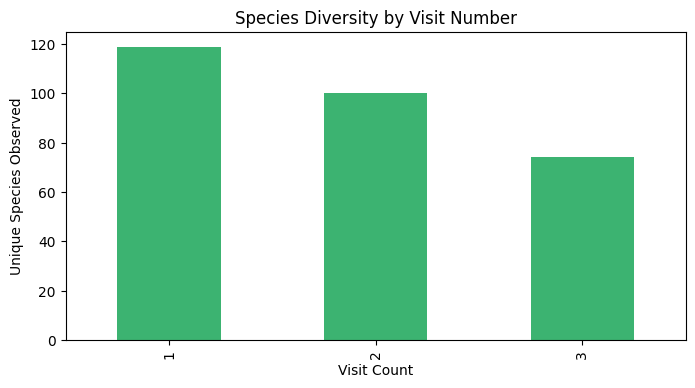

In [68]:
# Average number of species per visit count
species_per_visit = combined_data.groupby('Visit')['Scientific_Name'].nunique()

species_per_visit.plot(
    kind='bar',
    title='Species Diversity by Visit Number',
    xlabel='Visit Count',
    ylabel='Unique Species Observed',
    color='mediumseagreen',
    figsize=(8, 4)
)

<Axes: title={'center': 'Total Observations by Visit Count'}, xlabel='Visit Number', ylabel='Observation Count'>

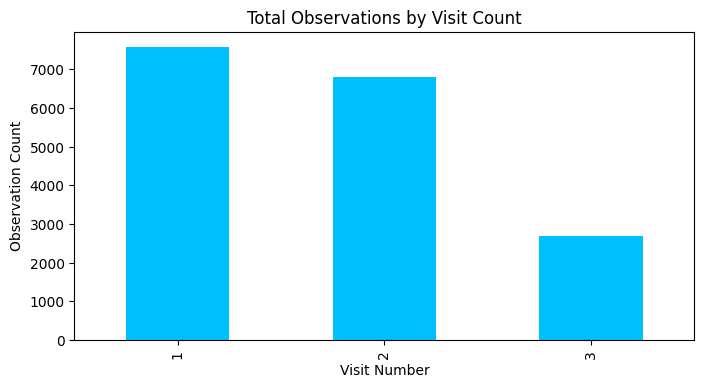

In [69]:
combined_data['Visit'].value_counts().sort_index().plot(
    kind='bar',
    title='Total Observations by Visit Count',
    xlabel='Visit Number',
    ylabel='Observation Count',
    color='deepskyblue',
    figsize=(8, 4)
)

In [70]:
watchlist_species = combined_data[combined_data['PIF_Watchlist_Status'] == True]['Scientific_Name'].nunique()
print("🔴 Unique species on PIF Watchlist:", watchlist_species)

🔴 Unique species on PIF Watchlist: 8


<Axes: title={'center': 'Watchlist Species by Habitat Type'}, xlabel='Location Type', ylabel='Unique Watchlist Species'>

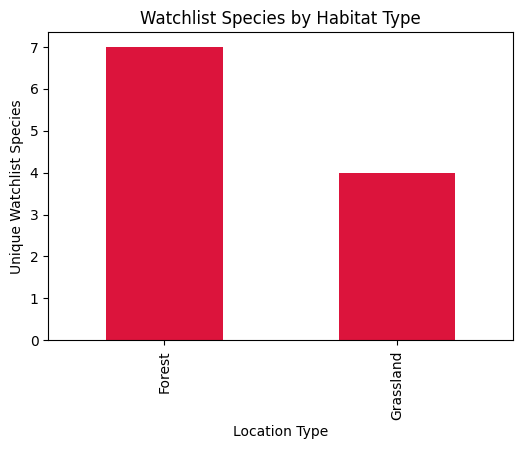

In [71]:
combined_data[combined_data['PIF_Watchlist_Status'] == True].groupby('Location_Type')['Scientific_Name'].nunique().plot(
    kind='bar',
    title='Watchlist Species by Habitat Type',
    xlabel='Location Type',
    ylabel='Unique Watchlist Species',
    color='crimson',
    figsize=(6, 4)
)

<Axes: title={'center': 'Top 10 Watchlist Species Observed'}, xlabel='Species', ylabel='Observation Count'>

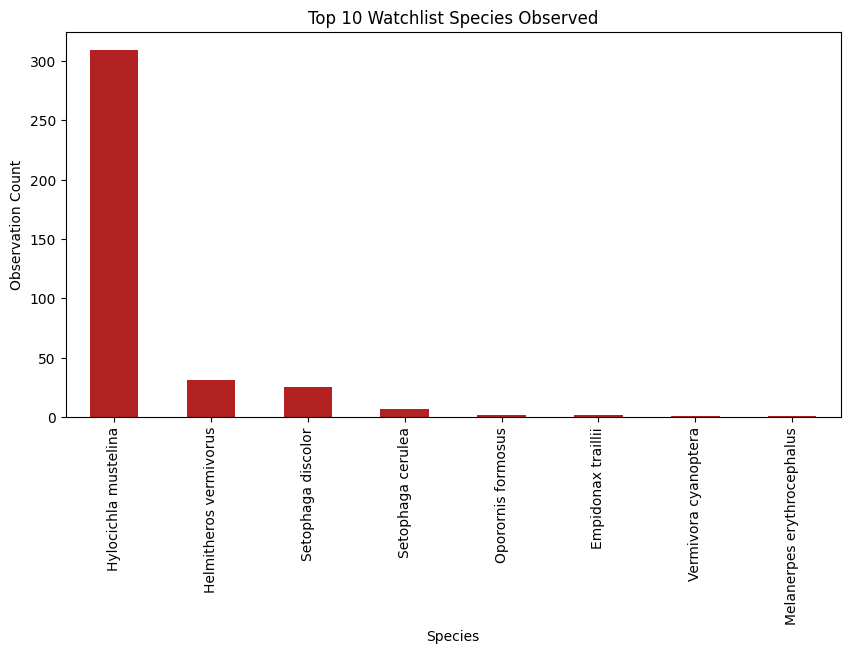

In [72]:
combined_data[combined_data['PIF_Watchlist_Status'] == True]['Scientific_Name'].value_counts().head(10).plot(
    kind='bar',
    title='Top 10 Watchlist Species Observed',
    xlabel='Species',
    ylabel='Observation Count',
    color='firebrick',
    figsize=(10, 5)
)

In [73]:
regional_species = combined_data[combined_data['Regional_Stewardship_Status'] == True]['Scientific_Name'].nunique()
print("🟡 Unique species under Regional Stewardship:", regional_species)

🟡 Unique species under Regional Stewardship: 21


<Axes: title={'center': 'Regional Stewardship Species by Habitat'}, xlabel='Location Type', ylabel='Unique Stewardship Species'>

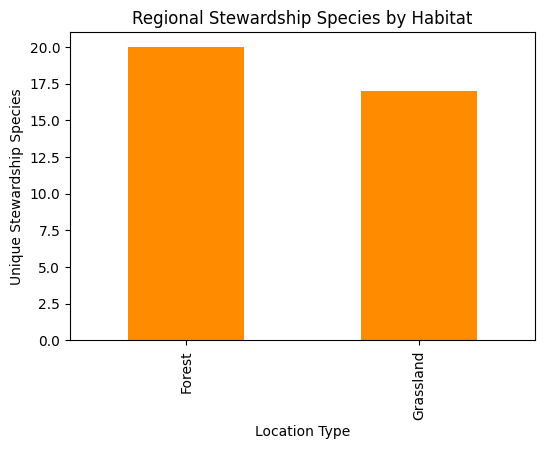

In [74]:
combined_data[combined_data['Regional_Stewardship_Status'] == True].groupby('Location_Type')['Scientific_Name'].nunique().plot(
    kind='bar',
    title='Regional Stewardship Species by Habitat',
    xlabel='Location Type',
    ylabel='Unique Stewardship Species',
    color='darkorange',
    figsize=(6, 4)
)

<Axes: title={'center': 'Top 10 Species by AOU Code'}, xlabel='AOU Code', ylabel='Observation Count'>

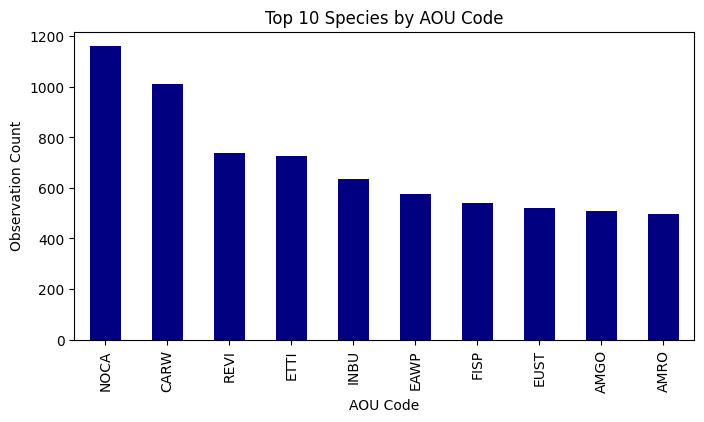

In [75]:
combined_data['AOU_Code'].value_counts().head(10).plot(
    kind='bar',
    title='Top 10 Species by AOU Code',
    xlabel='AOU Code',
    ylabel='Observation Count',
    color='navy',
    figsize=(8, 4)
)

<Axes: title={'center': 'Most Observed AOU Codes in Watchlist Species'}, xlabel='AOU Code', ylabel='Observation Count'>

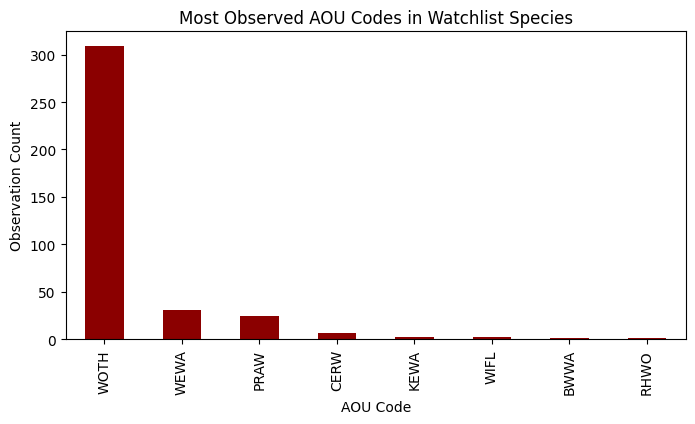

In [76]:
aou_watchlist = combined_data[combined_data['PIF_Watchlist_Status'] == True]['AOU_Code'].value_counts().head(10)

aou_watchlist.plot(
    kind='bar',
    title='Most Observed AOU Codes in Watchlist Species',
    xlabel='AOU Code',
    ylabel='Observation Count',
    color='darkred',
    figsize=(8, 4)
)

In [77]:
combined_data.to_csv('/Users/mahakagrawal/Desktop/Cleaned_Bird_Observation_Data.csv', index=False)
